### Model Optimization Notebook

#### Import libraries and data

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from scipy.stats import mode
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns

sns.color_palette("Set2", 10)
%matplotlib inline

In [3]:
df_X_total = pd.read_csv('InstacartFeatures.csv',index_col=0)

#### Train Test Split + Holdout

In [4]:
# split data
# holdout 20% for final test

np.random.seed(42)
total_users = df_X_total['user_id'].unique() 
holdout_users = np.random.choice(total_users, size=int(total_users.shape[0] * .20), replace=False)

# populate training data with users not in the holdout set
# populate holdout test data with users from the holdout set

df_X_model = df_X_total[~df_X_total['user_id'].isin(holdout_users)]

df_X_holdout = df_X_total[df_X_total['user_id'].isin(holdout_users)] 
    
# train validation split
# make sure train users are not in validation set

model_users = df_X_model['user_id'].unique() 
val_users = np.random.choice(model_users, size=int(model_users.shape[0] * .20), replace=False)

# drop unusable columns from train + val (categorical features/indices used as groupby keys)

df_X_train = df_X_model[~df_X_model['user_id'].isin(val_users)]
df_X_val = df_X_model[df_X_model['user_id'].isin(val_users)]

y_train = df_X_train['in_cart']
y_val = df_X_val['in_cart']

X_train = df_X_train.drop(['product_id','user_id','latest_cart','in_cart', \
                                         'product_name','aisle_id','department_id','aisle','department', \
                                         'train_user_order_number','prior_user_product_last_order'],axis=1)
X_val = df_X_val.drop(['product_id','user_id','latest_cart','in_cart', \
                                'product_name','aisle_id','department_id','aisle','department', \
                                'train_user_order_number','prior_user_product_last_order'],axis=1)



In [5]:
model_users.shape

(4000,)

In [6]:
val_users.shape

(800,)

In [139]:
X_train.columns

Index(['user_product_total_orders', 'product_total_orders',
       'product_avg_add_to_cart_order', 'user_total_orders',
       'user_avg_cartsize', 'user_total_products',
       'user_avg_days_since_prior_order', 'user_product_avg_add_to_cart_order',
       'user_product_order_freq', 'aisle_baby food formula',
       'aisle_baking ingredients', 'aisle_candy chocolate',
       'aisle_chips pretzels', 'aisle_cleaning products', 'aisle_coffee',
       'aisle_cookies cakes', 'aisle_crackers', 'aisle_energy granola bars',
       'aisle_frozen meals', 'aisle_hair care', 'aisle_ice cream ice',
       'aisle_juice nectars', 'aisle_other', 'aisle_packaged cheese',
       'aisle_refrigerated', 'aisle_soup broth bouillon',
       'aisle_spices seasonings', 'aisle_tea', 'aisle_vitamins supplements',
       'aisle_yogurt', 'dept_alcohol', 'dept_babies', 'dept_bakery',
       'dept_beverages', 'dept_breakfast', 'dept_bulk', 'dept_canned goods',
       'dept_dairy eggs', 'dept_deli', 'dept_dry goods

#### Model Evaluation Metrics

In [37]:
# get validation scores
# don't use built-in cross-val methods b/c in this case, they will leak user info into validation set

def get_metrics(estimator, X, y, X_te, y_te):
    results = {}
    model = estimator.fit(X,y)
    y_pred = model.predict(X_te)
    metrics = [f1_score, precision_score, recall_score, accuracy_score]
    names = ['f1', 'precision', 'recall', 'accuracy']
    metric_tup = list(zip(metrics, names))
    for metric in metric_tup:
        score = metric[0](y_te, y_pred)
        results[metric[1]] = score
    return model, results

In [103]:
lr = get_metrics(LogisticRegression(C=1e7), X_train, y_train, X_val, y_val)
lr[1]

{'accuracy': 0.72863694670438772,
 'f1': 0.54580747625069848,
 'precision': 0.67351382739348187,
 'recall': 0.45881131329113922}

In [42]:
lr[0].predict(X_val)

array([0, 1, 0, ..., 1, 0, 0])

In [ ]:
# get classification report
# calculate the accuracy, precision, recall and f1 scores of each estimator 

estimators = [KNeighborsClassifier(n_neighbors=neighbors), GaussianNB(), DecisionTreeClassifier(),
              RandomForestClassifier(n_estimators=600)]
estimator_names = ['KNN', 'GaussianNB', 'DecisionTreeClassifier', 'RandomForestClassifier']
estimator_tuples = list(zip(estimators, estimator_names))

for estimator in estimator_tuples: 
    estimator[0].fit(X_train, y_train)
    y_predict = estimator[0].predict(X_val)
    class_report = classification_report(y_val, y_predict)
    print(estimator[1])
    print(class_report)
    print('-----------------')

In [104]:
# get Area Under the Curve 
# estimator must already be fit to X_train, y_train

def get_auc_roc(estimator, name, X_te, y_te):
    y_score = estimator.predict_proba(X_te)[:,1]

    fpr, tpr,_ = roc_curve(y_te, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    # Plotting our Baseline..
    plt.plot([0,1],[0,1], color='navy', lw=1, linestyle='--')
    plt.plot(fpr,tpr, color='darkorange', label='ROC Curve (area={0:.4f})'.format(roc_auc))
    plt.title('{} ROC Curve'.format(name), fontsize=15)
    plt.xlabel('FPR', fontsize=15)
    plt.ylabel('TPR', fontsize=15)
    plt.legend(loc='lower right')
    plot = plt.show();
    
    return plot

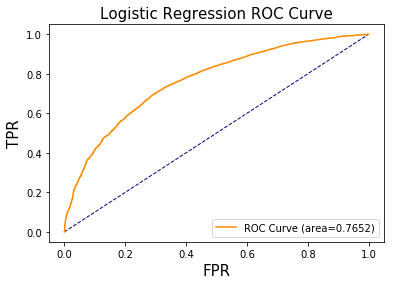

In [105]:
roc = get_auc_roc(lr[0], 'Logistic Regression', X_val, y_val)
roc

### Imbalanced Data

#### Tuning Probability Threshold to Optimize F1

In [109]:
# Adjust P threshold to optimize F1
# estimator must already be fit

def optimize_pthresh(estimator, X_te, y_te):
    thresh_ps = np.linspace(.10,.50,1000)
    model_val_probs = estimator.predict_proba(X_te)[:,1] # positive class probabilities 

    f1_scores = []
    for p in thresh_ps:
        model_val_labels = model_val_probs >= p
        f1_scores.append(f1_score(model_val_labels, y_te))

    best_f1_score = np.max(f1_scores) 
    best_thresh_p = thresh_ps[np.argmax(f1_scores)]

    return best_thresh_p

def plot_pthresh(estimator, X_te, y_te):
    thresh_ps = np.linspace(.10,.50,1000)
    model_val_probs = estimator.predict_proba(X_te)[:,1] # positive class probabilities 

    f1_scores = []
    for p in thresh_ps:
        model_val_labels = model_val_probs >= p
        f1_scores.append(f1_score(model_val_labels, y_te))

    best_f1_score = np.max(f1_scores) 
    best_thresh_p = thresh_ps[np.argmax(f1_scores)]
    
    plt.plot(thresh_ps, f1_scores)
    plt.title('F1 Score vs. Positive Class Decision Probability Threshold', fontsize=15)
    plt.xlabel('P threshold', fontsize=15)
    plt.ylabel('F1 score', fontsize=15)
    plt.show();

    return ('Model best F1 score %.3f at prob decision threshold >= %.3f' 
          % (best_f1_score, best_thresh_p)) 
      

In [107]:
best_p = optimize_pthresh(lr[0], X_val, y_val)
best_p

0.29339339339339343

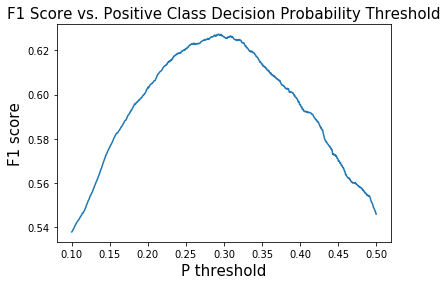

'Model best F1 score 0.627 at prob decision threshold >= 0.293'

In [110]:
plot_pthresh(lr[0], X_val, y_val)

In [115]:
# Decision Tree

dt = DecisionTreeClassifier(max_depth=8).fit(X_train, y_train)

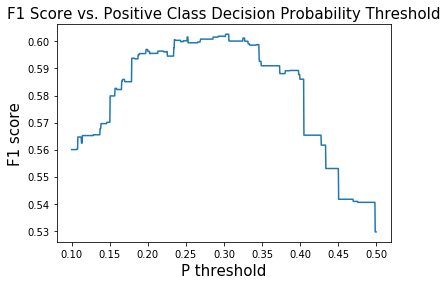

'Model best F1 score 0.603 at prob decision threshold >= 0.302'

In [116]:
plot_pthresh(dt, X_val, y_val)

In [111]:
# now let's try with Random Forest

rf = RandomForestClassifier(n_estimators=1000).fit(X_train, y_train)

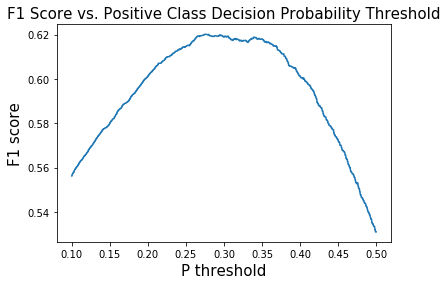

'Model best F1 score 0.620 at prob decision threshold >= 0.275'

In [112]:
plot_pthresh(rf, X_val, y_val)

0.550564454164


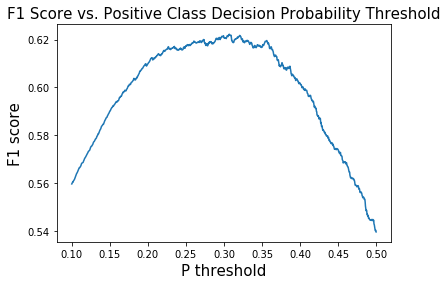

'Model best F1 score 0.622 at prob decision threshold >= 0.307'

In [134]:
# xgboost

gbm = xgb.XGBClassifier( 
                        n_estimators=300,
                        max_depth=7,
                        objective='binary:logistic',
                        learning_rate=.1, 
                        scale_pos_weight = 1,
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8
                       )

eval_set=[(X_train,y_train),(X_val,y_val)]

fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='auc',
                    early_stopping_rounds=50,
                    verbose=False
                   )

xgb_f1 = f1_score(y_val, gbm.predict(X_val, ntree_limit=gbm.best_ntree_limit))
print(xgb_f1)

plot_pthresh(gbm, X_val, y_val)

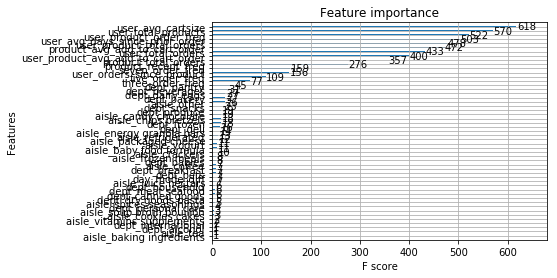

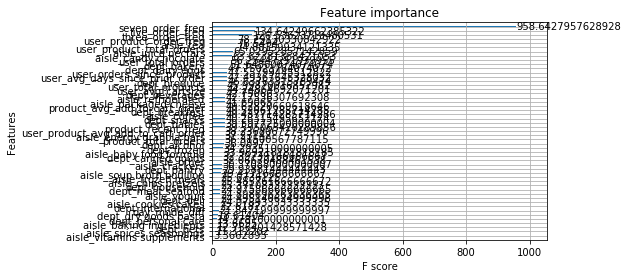

In [135]:
xgb.plot_importance(gbm)
xgb.plot_importance(gbm, importance_type='gain')

In [137]:
gbm.get_booster().get_score(importance_type='weight') #extract raw frequency scores

{'aisle_baby food formula': 11,
 'aisle_baking ingredients': 1,
 'aisle_candy chocolate': 19,
 'aisle_chips pretzels': 18,
 'aisle_coffee': 7,
 'aisle_cookies cakes': 3,
 'aisle_crackers': 10,
 'aisle_energy granola bars': 14,
 'aisle_frozen meals': 8,
 'aisle_juice nectars': 7,
 'aisle_other': 26,
 'aisle_packaged cheese': 12,
 'aisle_refrigerated': 13,
 'aisle_soup broth bouillon': 3,
 'aisle_spices seasonings': 5,
 'aisle_tea': 1,
 'aisle_vitamins supplements': 2,
 'aisle_yogurt': 11,
 'day_mode_diff': 7,
 'dept_alcohol': 1,
 'dept_babies': 8,
 'dept_bakery': 27,
 'dept_beverages': 31,
 'dept_breakfast': 7,
 'dept_canned goods': 6,
 'dept_dairy eggs': 27,
 'dept_deli': 16,
 'dept_dry goods pasta': 5,
 'dept_frozen': 18,
 'dept_household': 6,
 'dept_international': 2,
 'dept_meat seafood': 6,
 'dept_pantry': 45,
 'dept_personal care': 4,
 'dept_pets': 7,
 'dept_produce': 19,
 'dept_snacks': 23,
 'five_order_freq': 109,
 'product_avg_add_to_cart_order': 472,
 'product_recent_freq': 27

In [138]:
gbm.get_booster().get_score(importance_type='gain') #extract raw gain scores

{'aisle_baby food formula': 33.969218181818185,
 'aisle_baking ingredients': 13.6695,
 'aisle_candy chocolate': 63.62381368421053,
 'aisle_chips pretzels': 25.485761666666672,
 'aisle_coffee': 40.437714285714286,
 'aisle_cookies cakes': 24.078933333333335,
 'aisle_crackers': 30.370880000000007,
 'aisle_energy granola bars': 37.23142,
 'aisle_frozen meals': 25.6736125,
 'aisle_juice nectars': 65.02952857142859,
 'aisle_other': 32.06670488461538,
 'aisle_packaged cheese': 41.69065,
 'aisle_refrigerated': 42.17536307692308,
 'aisle_soup broth bouillon': 29.41716666666667,
 'aisle_spices seasonings': 11.312202,
 'aisle_tea': 76.5494,
 'aisle_vitamins supplements': 3.3662895,
 'aisle_yogurt': 24.898696363636365,
 'day_mode_diff': 21.847199999999997,
 'dept_alcohol': 36.0897,
 'dept_babies': 39.597725000000004,
 'dept_bakery': 51.64860074074074,
 'dept_beverages': 42.75066,
 'dept_breakfast': 40.52061285714285,
 'dept_canned goods': 32.39739166666667,
 'dept_dairy eggs': 47.75023764074072,
 

#### Class Weights or Oversampling?